# 第6章 卷积神经网络

## 6.1 从全连接层到卷积

### 练习 6.1.1

假设卷积层(6.3)覆盖的局部区域$\Delta = 0$。在这种情况下，证明卷积内核为每组通道独立地实现一个全连接层。

**解答：** 

&emsp;&emsp;局部区域$\Delta=0$ 表示卷积核的大小等于输入的大小。实际就是问，1×1的卷积核是否等价于全连接（参见本书7.3节：NiN网络结构）。因此，每个卷积核只能覆盖一个像素点，在这种情况下，卷积层的计算方式与全连接层非常相似。因为每个卷积核只能看到一个通道的信息，相当于每个卷积核只是一个全连接层的权重矩阵。 所以，卷积内核可以看作是每组通道独立地实现一个全连接层。每个卷积核都有自己的权重，每个输入通道都被独立处理，输出通道是各个输入通道的加权和。这种独立处理的方式有效地减少了权重的数量，从而降低了计算成本，并且能够提取出输入数据中的空间特征。

In [1]:
# 代码验证
# 导入PyTorch库
import torch
import torch.nn as nn

# 定义一个神经网络类MyNet1，继承自nn.Module
class MyNet1(nn.Module):
    def __init__(self, linear1, linear2):
        super(MyNet1, self).__init__()
        # 初始化两个线性层
        self.linear1 = linear1
        self.linear2 = linear2

    def forward(self, X):
        # 定义前向传播过程：先展平输入X，然后通过两个线性层
        return self.linear2(self.linear1(nn.Flatten()(X)))

# 定义另一个神经网络类MyNet2，也继承自nn.Module
class MyNet2(nn.Module):
    def __init__(self, linear, conv2d):
        super(MyNet2, self).__init__()
        # 初始化一个线性层和一个卷积层
        self.linear = linear
        self.conv2d = conv2d

    def forward(self, X):
        # 定义前向传播过程
        X = self.linear(nn.Flatten()(X))  # 先展平输入X，然后通过线性层
        X = X.reshape(X.shape[0], -1, 1, 1)  # 调整X的形状以适应卷积层的输入
        X = nn.Flatten()(self.conv2d(X))  # 通过卷积层，然后再次展平
        return X

# 初始化线性层和卷积层
linear1 = nn.Linear(15, 10)
linear2 = nn.Linear(10, 5)
conv2d = nn.Conv2d(10, 5, 1)

# 将卷积层的权重和偏置参数重塑并分别赋值给linear2的权重和偏置
linear2.weight = nn.Parameter(conv2d.weight.reshape(linear2.weight.shape))
linear2.bias = nn.Parameter(conv2d.bias)

# 实例化两个网络
net1 = MyNet1(linear1, linear2)
net2 = MyNet2(linear1, conv2d)

# 创建一个随机输入张量X
X = torch.randn(2, 3, 5)
# 打印两个网络对同一输入X的输出结果
# 两个结果实际存在一定的误差，直接print(net1(X) == net2(X))得到的结果不全是True
print(net1(X))
print(net2(X))

tensor([[ 0.3899,  0.0479, -0.2126,  0.1792,  0.3500],
        [ 0.2926,  0.1829, -0.2421,  0.4840, -0.6991]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.3899,  0.0479, -0.2126,  0.1792,  0.3500],
        [ 0.2926,  0.1829, -0.2421,  0.4840, -0.6991]],
       grad_fn=<ReshapeAliasBackward0>)


### 练习 6.1.2

为什么平移不变性可能也不是好主意呢？

**解答：** 

&emsp;&emsp;平移不变性是一种在信号处理和图像分析中常见的特性，尤其是在卷积神经网络（`CNNs`）中。它意味着一个系统或函数对输入数据的平移是不变的，即如果输入数据发生平移，输出不会改变。这对于很多应用来说是有益的，比如在图像识别中，无论物体在图像中的位置如何，模型都能识别它。\
&emsp;&emsp;平移不变性可能也存在一些局限性或不足之处:\
&emsp;&emsp;1.**丢失空间信息**：当模型对位置不敏感时，它可能无法识别对象的确切位置或对象之间的空间关系。在某些任务中，如场景理解或对象定位，这种空间信息非常重要。\
&emsp;&emsp;2.**不适用于所有任务**：对于一些特定的任务，如图像中文本的识别或布局分析，平移不变性可能不是一个理想的特性，因为这些任务需要对位置和排列非常敏感。\
&emsp;&emsp;3.**过度泛化**：平移不变性可能导致模型过度泛化，无法识别某些应该被视为不同的模式或对象。例如，在医学成像分析中，肿瘤的确切位置对于诊断至关重要。\
&emsp;&emsp;4.**缩放和旋转问题**：虽然平移不变性处理位置的变化，但它不处理缩放或旋转，这可能是图像识别中的关键因素。\
&emsp;&emsp;5.**计算效率**：为了实现平移不变性，卷积网络通常需要更多的参数和计算资源，这可能导致效率低下，尤其是在资源受限的环境中。\
&emsp;&emsp;6.**局部性限制**：平移不变性通常通过局部感受野实现，这可能限制模型捕捉长距离依赖或大尺度结构的能力。

&emsp;&emsp;参考：[https://arxiv.org/pdf/1805.12177.pdf](https://arxiv.org/pdf/1805.12177.pdf)

### 练习 6.1.3

当从图像边界像素获取隐藏表示时，我们需要思考哪些问题？

**解答：** 

&emsp;&emsp;从图像边界像素获取隐藏表示时，需要考虑一些特定的问题和挑战：\
&emsp;&emsp;1. **边界效应**：在图像边界处，像素的上下文信息可能不完整，这可能导致在提取特征时出现边界效应。边界像素没有足够的邻近像素来形成完整的局部模式，这可能影响隐藏表示的质量。\
&emsp;&emsp;2. **信息丢失**：边界像素通常不如图像中心区域的像素具有丰富的信息。在处理边界像素时，可能会丢失对整体图像理解至关重要的上下文信息。\
&emsp;&emsp;3. **尺度和旋转问题**：在边界区域，图像的尺度和旋转变化可能对隐藏表示产生更大的影响，尤其是在处理尺寸不一或旋转图像时。\
&emsp;&emsp;4. **填充策略的选择**：在使用卷积神经网络等工具时，可能需要对边界进行填充（如零填充）以保持特征图的尺寸。不同的填充策略可能会对边界像素的隐藏表示产生不同的影响。\
&emsp;&emsp;5. **噪声和伪影**：边界区域可能更容易受到图像处理过程中引入的噪声和伪影的影响，这可能会干扰隐藏表示的准确性。\
&emsp;&emsp;6. **特定应用的需求**：根据应用的不同，边界像素的处理方式可能需要调整。例如，在某些任务中，边界信息可能尤为重要，而在其他任务中，则可能不那么重要。\
&emsp;&emsp;为了有效地从图像边界像素获取隐藏表示，可能需要采用特殊的技术和策略，如使用特殊的卷积核、采用适应性边界处理方法或通过数据增强来模拟边界效应。此外，了解和评估边界像素对最终任务的影响也是很重要的。

### 练习 6.1.4

描述一个类似的音频卷积层的架构。

**解答：** 

&emsp;&emsp;一种基于卷积神经网络的音频特征生成方法，首先对声音信号进行预处理和离散傅里叶变换计算声音信号的幅度谱，形成二维谱图信号；然后搭建以上述二维谱图信号为输入的一维卷积神经网络并进行模型训练，得到特征生成器模型；最后对待测声音进行预处理和离散傅里叶变换得到二维谱图信号，并将其送入训练好的一维卷积神经网络，通过卷积网络计算，得到输出即为所要生成的音频特征，实现声音信号的音频特征生成。

&emsp;&emsp;参考：https://blog.csdn.net/david_tym/article/details/112756785

### 练习 6.1.5

卷积层也适合于文本数据吗？为什么？

**解答：** 

&emsp;&emsp;卷积层也适合于文本数据。\
&emsp;&emsp;在自然语言处理中，文本数据通常表示为词向量矩阵，其中每行代表一个词的向量表示。卷积层可以在这个矩阵上进行卷积操作，类似于图像卷积层中对图像进行卷积操作。 在卷积层中，卷积核会在输入矩阵上进行滑动窗口计算，输出一个新的特征矩阵。在文本数据中，这个特征矩阵可以看作是对输入文本的不同`n-gram`特征的提取。例如，一个大小为3的卷积核可以提取出输入文本中每个长度为3的n-gram特征。这些特征可以用于后续的分类或者回归任务。 此外，卷积层还可以与循环神经网络（`RNN`）结合使用，形成卷积神经网络（`CNN`）和循环神经网络（`RNN`）的混合模型。这种模型可以同时捕捉文本中的局部特征和全局特征，提高模型的性能。 因此，卷积层适用于文本数据，可以对文本数据进行卷积操作，提取出不同`n-gram`特征，并且可以与`RNN`结合使用，提高模型的性能。

### 练习 6.1.6

证明在式(6.6)中，$f * g = g * f$。

**解答：** 

&emsp;&emsp;通过式(6.6)的定义，我们可以得到：

$$(f * g)(x) = \int_{-\infty}^{\infty}f(y)g(x-y)dy$$

$$(g * f)(x) = \int_{-\infty}^{\infty}g(y)f(x-y)dy$$

&emsp;&emsp;要证明$f * g = g * f$，即证明：

$$\int_{-\infty}^{\infty}f(y)g(x-y)dy = \int_{-\infty}^{\infty}g(y)f(x-y)dy$$

&emsp;&emsp;为了证明上式成立，我们将其中一个积分的变量名改为$t=x-y$，则有：

$$\int_{-\infty}^{\infty}f(y)g(x-y)dy = \int_{-\infty}^{\infty}f(x-t)g(t)dt$$

&emsp;&emsp;再将这个式子代回式(6.6)中：

$$(f * g)(x) = \int_{-\infty}^{\infty}f(x-t)g(t)dt$$

&emsp;&emsp;对比式(6.6)和上面的式子，可以发现它们的形式是完全一样的，只是积分变量名不同而已。因此，我们可以得到：

$$(f * g)(x) = \int_{-\infty}^{\infty}f(y)g(x-y)dy = \int_{-\infty}^{\infty}g(y)f(x-y)dy = (g * f)(x)$$

&emsp;&emsp;因此，$f * g = g * f$，证毕。



## 6.2 图像卷积

### 练习 6.2.1  

构建一个具有对角线边缘的图像`X`。
1. 如果将本节中举例的卷积核`K`应用于`X`，会发生什么情况？
2. 如果转置`X`会发生什么？
3. 如果转置`K`会发生什么？

**解答：** 

**第1问：**

&emsp;&emsp;在对角线处有分别为1和-1的数据，其他区域都为0。

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape  # 获取卷积核的高度和宽度
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))  # 初始化输出矩阵 Y，大小为 (X行数 - K行数 + 1) x (X列数 - K列数 + 1)
    for i in range(Y.shape[0]):  # 遍历 Y 的行数
        for j in range(Y.shape[1]):  # 遍历 Y 的列数
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()  # 在 Y 的每个位置，计算 X 与 K 的互相关运算结果
    return Y

# 创建一个8x8的单位矩阵 X
X = torch.eye(8)
# 创建一个1x2的卷积核 K，该卷积核在X上进行互相关运算
K = torch.tensor([[1.0, -1.0]])
# 调用corr2d函数，计算互相关运算结果Y
Y = corr2d(X, K)
# 打印互相关运算结果Y
print(Y)

tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.]])


**第2问：**

&emsp;&emsp;X转置后，结果不变。

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape  # 获取卷积核的高度和宽度
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))  # 初始化输出矩阵 Y，大小为 (X行数 - K行数 + 1) x (X列数 - K列数 + 1)
    for i in range(Y.shape[0]):  # 遍历 Y 的行数
        for j in range(Y.shape[1]):  # 遍历 Y 的列数
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()  # 在 Y 的每个位置，计算 X 与 K 的互相关运算结果
    return Y

# 创建一个8x8的单位矩阵 X
X = torch.eye(8)
# 创建一个1x2的卷积核 K，该卷积核在X的转置上进行互相关运算
K = torch.tensor([[1.0, -1.0]])
# 调用corr2d函数，计算互相关运算结果Y
Y = corr2d(X.T, K) # 在 X 的转置上应用卷积核 K，得到卷积响应图像 Y
# 打印互相关运算结果 Y
Y

tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.]])

**第3问：**

&emsp;&emsp;K转置后，结果也会发生转置 

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape  # 获取卷积核的高度和宽度
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))  # 初始化输出矩阵 Y，大小为 (X行数 - K行数 + 1) x (X列数 - K列数 + 1)
    for i in range(Y.shape[0]):  # 遍历 Y 的行数
        for j in range(Y.shape[1]):  # 遍历 Y 的列数
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()  # 在 Y 的每个位置，计算 X 与 K 的互相关运算结果
    return Y

# 创建一个8x8的单位矩阵 X
X = torch.eye(8)
# 创建一个1x2的卷积核 K，将其转置后与 X 进行互相关运算
K = torch.tensor([[1.0, -1.0]])
# 调用 corr2d 函数，计算互相关运算结果 Y
Y = corr2d(X, K.T) # 在 X 应用卷积核 K 的转置，得到卷积响应图像 Y
# 打印互相关运算结果 Y
Y

tensor([[ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]])

### 练习 6.2.2 

在我们创建的`Conv2D`自动求导时，有什么错误消息？

**解答：** 

&emsp;&emsp;会提示维度不对称的错误信息，因为torch提供的二维卷积层是nn.Conv2d() 采用的是四维输入和输出格式（批量大小、通道、高度、宽度）,而我们自定义的仅仅是二维的。

&emsp;&emsp;代码验证如下(使用`nn.Conv2d`)

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

X = d2l.ones((6, 8))
X[:, 2:6] = 0
X
K = d2l.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y
corr2d(d2l.transpose(X), K)
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')


epoch 2, loss 2.518
epoch 4, loss 0.649
epoch 6, loss 0.201
epoch 8, loss 0.072
epoch 10, loss 0.028


&emsp;&emsp;使用创建的`Conv2D`时可以会报如下错误

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

X = d2l.ones((6, 8))
X[:, 2:6] = 0
X
K = d2l.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y
corr2d(d2l.transpose(X), K)

conv2d = Conv2D(kernel_size=(1, 2)) # 使用正确的 kernel_size 参数

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

try:
    for i in range(10):
        Y_hat = conv2d(X)
        l = (Y_hat - Y) ** 2
        conv2d.zero_grad()
        l.sum().backward()
        # 迭代卷积核
        conv2d.weight.data[:] -= lr * conv2d.weight.grad
        if (i + 1) % 2 == 0:
            print(f'epoch {i+1}, loss {l.sum():.3f}')
except Exception as e:
    print(e)

The size of tensor a (0) must match the size of tensor b (7) at non-singleton dimension 3


&emsp;&emsp;可以通过下述方式调整

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

X = d2l.ones((6, 8))
X[:, 2:6] = 0
X
K = d2l.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y
corr2d(d2l.transpose(X), K)

conv2d = Conv2D(kernel_size=(1, 2))

X = X.reshape((6, 8))
Y = Y.reshape((6, 7))
lr = 3e-2  # 学习率

try:
    for i in range(10):
        Y_hat = conv2d(X)
        l = (Y_hat - Y) ** 2
        conv2d.zero_grad()
        l.sum().backward()
        # 迭代卷积核
        conv2d.weight.data[:] -= lr * conv2d.weight.grad
        if (i + 1) % 2 == 0:
            print(f'epoch {i+1}, loss {l.sum():.3f}')
except Exception as e:
    print(e)

epoch 2, loss 8.875
epoch 4, loss 2.393
epoch 6, loss 0.772
epoch 8, loss 0.281
epoch 10, loss 0.109


### 练习 6.2.3

如何通过改变输入张量和卷积核张量，将互相关运算表示为矩阵乘法？

**解答：** 

&emsp;&emsp;题目的意思应该是如何通过矩阵乘法得到互相关（卷积）运算

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

def conv2d_by_mul(X, K):
    # 获取卷积核大小
    h, w = K.shape
    # 计算输出图像大小
    outh = X.shape[0] - h + 1
    outw = X.shape[1] - w + 1
    # 调整卷积核形状以便做乘法
    K = K.reshape(-1, 1)
    # 将输入图像切成卷积核大小的块，打平成一维，存放在列表 Y 中
    Y = []
    for i in range(outh):
        for j in range(outw):
            Y.append(X[i:i + h, j:j + w].reshape(-1))
    # 将列表 Y 转为张量，每行代表一块的打平结果
    Y = torch.stack(Y, 0)
    # 用矩阵乘法表示互相关运算
    res = (torch.matmul(Y, K)).reshape(outh, outw)
    # 返回输出结果
    return res

#示例
# 创建一个2x3的输入图像 X，其中第二列的元素被设置为0
X = torch.ones((2, 3))
X[:, 1] = 0  # 将第二列的所有元素设置为0
# 打印输入图像 X
print(X)
# 创建一个2x3的卷积核 K，所有元素均为1
K = torch.ones((2, 3))
# 调用自定义的 conv2d_by_mul 函数来执行二维互相关运算
output = conv2d_by_mul(X, K)
# 打印互相关运算的结果
print(output)

tensor([[1., 0., 1.],
        [1., 0., 1.]])
tensor([[4.]])


### 练习 6.2.4

手工设计一些卷积核。
1. 二阶导数的核的形式是什么？
1. 积分的核的形式是什么？
1. 得到$d$次导数的最小核的大小是多少？

**解答：** 

**第1问：**

&emsp;&emsp;一维的二阶导数的核的形式是：

$$\begin{bmatrix}-1, & 2, & -1,\end{bmatrix}$$

&emsp;&emsp;这个一维卷积核可以用于计算信号或函数在每个点的二阶导数。它通过对信号进行两次微分来强调信号的曲率和变化率，通常用于边缘检测和特征检测等任务。

&emsp;&emsp;在二维情况下，可以使用以下卷积核来计算图像的二阶导数：

\begin{bmatrix}
    0, &  1, & 0 \\
    1, & -4, & 1 \\
    0, &  1, & 0 \\
\end{bmatrix}




**第2问：**

&emsp;&emsp;积分的核的形式是：

$$\begin{bmatrix}1 & 1 & 1 & \cdots & 1\end{bmatrix}$$


**第3问：**

&emsp;&emsp;得到 𝑑 次导数的最小核的大小是 $d+1$。例如，一阶导数的最小核大小为 $2$，二阶导数的最小核大小为 $3$，三阶导数的最小核大小为 $4$，以此类推。

## 6.3 填充和步幅 

### 练习 6.3.1  

对于本节中的最后一个示例，计算其输出形状，以查看它是否与实验结果一致。

**解答：** 

$$out_{shape}=\lfloor(n_h-k_h+p_h*2+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w*2+s_w)/s_w\rfloor.$$

&emsp;&emsp;示例中$X.shape = [8, 8]$，计算得出$out_shape = [(8-3+0+3)/3, (8-5+2+4)/4] = [2.67, 2.25]$,向下取整，所以为$[2, 2]$



&emsp;&emsp; 代码验证如下

In [9]:
import torch
from torch import nn

# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
X = torch.rand(size=(8, 8))
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

### 练习 6.3.2

在本节中的实验中，试一试其他填充和步幅组合。

**解答：** 

&emsp;&emsp; 下面将举两个其他的填充和步幅组合

In [10]:
import torch
from torch import nn

# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
X = torch.rand(size=(8, 8))
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(1, 2), stride=(2, 3))
comp_conv2d(conv2d, X).shape

torch.Size([4, 3])

&emsp;&emsp;在`padding`大小为$[1,2]$，`stride`大小为$[2,3]$时，输出形状为$[4,3]$

&emsp;&emsp;示例中$X.shape = [8, 8]$，计算得出$out_{shape} = [(8-3+2+2)/2, (8-5+4+3)/3] = [4.5, 3,33]$,向下取整，所以为$[4, 3]$

In [11]:
import torch
from torch import nn

# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
X = torch.rand(size=(8, 8))
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(2, 3), stride=(1, 2))
comp_conv2d(conv2d, X).shape

torch.Size([10, 5])

&emsp;&emsp;在`padding`大小为$[2,3]$，`stride`大小为$[1,2]$时，输出形状为$[10,5]$

&emsp;&emsp;示例中$X.shape = [8, 8]$，计算得出$out_{shape} = [(8-3+4+1)/1, (8-5+6+2)/2] = [10, 5.5]$,向下取整，所以为$[10, 5]$

### 练习 6.3.3

对于音频信号，步幅$2$说明什么？

**解答：** 

&emsp;&emsp;对于音频信号而言，步幅为2就是以2为周期对信号进行采样计算。

### 练习 6.3.4

步幅大于$1$的计算优势是什么？

**解答：** 

&emsp;&emsp;减小计算量， 减小内存占用， 提高模型的泛化能力和训练速度。

## 6.4 多输入多输出通道 

### 练习 6.4.1

假设我们有两个卷积核，大小分别为$k_1$和$k_2$（中间没有非线性激活函数）。
1. 证明运算可以用单次卷积来表示。
1. 这个等效的单个卷积核的维数是多少呢？
1. 反之亦然吗？

**解答：** 

**第1问：**

&emsp;&emsp;假设输入的图像大小为$W×H$，设卷积核1的大小为$k_1$，卷积核2的大小为$k2$，它们分别作用于输入矩阵$x$，得到的输出矩阵分别为$y_1$和$y_2$。则可以将$y1$与$y2$的每一个元素相加，得到最终输出矩阵$y$。

&emsp;&emsp;即：$$y[i][j] = y_1[i][j] + y_2[i][j]$$

&emsp;&emsp;可以将两个卷积核的大小相加，得到一个新的卷积核大小为$(k_1+k_2-1)×(k_1+k_2-1)$。然后可以将这个新的卷积核应用于输入图像，得到一个输出图像。这个输出图像的大小为$(W-k_1-k_2+2)×(H-k_1-k_2+2)$。

**第2问：**

&emsp;&emsp;可以使用一个大小为$(k_1+k_2-1)×(k_1+k_2-1)$的卷积核来表示这两个卷积核的运算。

**第3问：**

&emsp;&emsp;反之亦然。如果有一个大小为$k_1+k_2-1$的卷积核，可以将其分解为两个大小分别为$k1$和$k2$的卷积核。这两个卷积核之间没有非线性激活函数，所以它们的运算可以被视为一个单独的卷积核。

### 练习 6.4.2

假设输入为$c_i\times h\times w$，卷积核大小为$c_o\times c_i\times k_h\times k_w$，填充为$(p_h, p_w)$，步幅为$(s_h, s_w)$。
1. 前向传播的计算成本（乘法和加法）是多少？
1. 内存占用是多少？
1. 反向传播的内存占用是多少？
1. 反向传播的计算成本是多少？

**解答：** 

**第1问：**

&emsp;&emsp;前向计算成本为

$$flops_{forward} = c_i \times c_o \times k_h \times k_w \times m_h \times m_w$$

&emsp;&emsp;其中$m_h=\lfloor \frac{h+2p_h-k_h}{s_h}+1 \rfloor$, $m_w=\lfloor \frac{w+2p_w-k_w}{s_w}+1 \rfloor$


**第2问：**

&emsp;&emsp;输入需要$c_i*h*w$个浮点数，卷积核需要$c_o*c_i*k_h*k_w$个浮点数，输出需要$c_o*m_h*m_w$个浮点数。此外，还需要存储中间结果，即填充后的输入和反向传播时的梯度信息。因此，总内存占用为
$$memory_{forward}=(c_i+k_h-1)*(h+k_w-1)*c_0+2*c_i*h*w$$

**第3问：**

&emsp;&emsp;反向传播的内存作用与前向传播相同，总内存占用为
$$memory_{backward}=(c_i+k_h-1)*(h+k_w-1)*c_0+2*c_i*h*w$$

**第4问：**

&emsp;&emsp;反向计算成本为

$$flops_{backward} = c_i \times c_o \times k_h \times k_w \times m_h \times m_w$$

&emsp;&emsp;其中$m_h$和$m_w$的定义同上

### 练习 6.4.3

如果我们将输入通道$c_i$和输出通道$c_o$的数量加倍，计算数量会增加多少？如果我们把填充数量翻一番会怎么样？

**解答：** 

&emsp;&emsp;如果我们将输入通道$c_i$和输出通道$c_o$的数量加倍，计算数量会增加$4$倍。如果我们把填充数量翻一番，计算数量会增加$2$倍。

### 练习 6.4.4

如果卷积核的高度和宽度是$k_h=k_w=1$，前向传播的计算复杂度是多少？

**解答：**

$$flops = c_i \times c_o \times \frac{h-p_h}{s_h} \times \frac{w-p_w}{s_w}$$

### 练习 6.4.5

本节最后一个示例中的变量`Y1`和`Y2`是否完全相同？为什么？

**解答：**

&emsp;&emsp;理论上相同，但由于浮点数计算有误差，因而两者不完全相同（有微小差异）。

### 练习 6.4.6

当卷积窗口不是$1\times 1$时，如何使用矩阵乘法实现卷积？

**解答：** 

&emsp;&emsp;可以将输入张量和卷积核张量分别展开为二维矩阵，然后对这两个矩阵进行乘法运算，得到的结果再变换为输出张量。

## 6.5 汇聚层 

### 练习 6.5.1

尝试将平均汇聚层作为卷积层的特殊情况实现。

**解答：** 

In [12]:
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module): 
    def init(self):
        super(Net, self).init()
        # 定义卷积层1，输入通道数为1，输出通道数为6，卷积核大小为5x5
        self.conv1 = nn.Conv2d(1, 6, 5)
        # 定义池化层，将6个通道的特征图进行平均池化
        self.pool = nn.Conv2d(6, 6, 5)
        # 定义卷积层2，输入通道数为6，输出通道数为16，卷积核大小为5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 定义全连接层1，输入大小为16x5x5，输出大小为120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 定义全连接层2，输入大小为120，输出大小为84
        self.fc2 = nn.Linear(120, 84)
        # 定义全连接层3，输入大小为84，输出大小为10（对应10个类别的分类）
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # 使用ReLU激活函数进行卷积层1的前向传播
        x = F.relu(self.conv1(x))
        # 使用平均池化进行池化层的前向传播
        x = F.avg_pool2d(x, (2, 2))
        # 使用ReLU激活函数进行卷积层2的前向传播
        x = F.relu(self.conv2(x))
        # 使用平均池化进行池化层的前向传播
        x = F.avg_pool2d(x, (2, 2))
        # 将特征图展平为一维向量
        x = x.view(-1, self.num_flat_features(x))
        # 使用ReLU激活函数进行全连接层1的前向传播
        x = F.relu(self.fc1(x))
        # 使用ReLU激活函数进行全连接层2的前向传播
        x = F.relu(self.fc2(x))
        # 全连接层3的前向传播，没有使用激活函数
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # 获取除了批量维度之外的其他维度的大小
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### 练习 6.5.2

尝试将最大汇聚层作为卷积层的特殊情况实现。

**解答：** 

In [13]:
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module): 
    def init(self):
        super(Net, self).init()
        # 定义卷积层1，输入通道数为1，输出通道数为6，卷积核大小为5x5
        self.conv1 = nn.Conv2d(1, 6, 5)
        # 定义池化层，将6个通道的特征图进行平均池化
        self.pool = nn.Conv2d(6, 6, 5)
        # 定义卷积层2，输入通道数为6，输出通道数为16，卷积核大小为5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 定义全连接层1，输入大小为16x5x5，输出大小为120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 定义全连接层2，输入大小为120，输出大小为84
        self.fc2 = nn.Linear(120, 84)
        # 定义全连接层3，输入大小为84，输出大小为10（对应10个类别的分类）
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # 使用ReLU激活函数进行卷积层1的前向传播
        x = F.relu(self.conv1(x))
        # 使用最大池化进行池化层的前向传播
        x = F.max_pool2d(x, (2, 2))
        # 使用ReLU激活函数进行卷积层2的前向传播
        x = F.relu(self.conv2(x))
        # 使用最大池化进行池化层的前向传播
        x = F.max_pool2d(x, (2, 2))
        # 将特征图展平为一维向量
        x = x.view(-1, self.num_flat_features(x))
        # 使用ReLU激活函数进行全连接层1的前向传播
        x = F.relu(self.fc1(x))
        # 使用ReLU激活函数进行全连接层2的前向传播
        x = F.relu(self.fc2(x))
        # 全连接层3的前向传播，没有使用激活函数
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # 获取除了批量维度之外的其他维度的大小
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### 练习 6.5.3

假设汇聚层的输入大小为$c\times h\times w$，则汇聚窗口的形状为$p_h\times p_w$，填充为$(p_h, p_w)$，步幅为$(s_h, s_w)$。这个汇聚层的计算成本是多少？

**解答：** 

$$flops=\frac{c \times h \times w \times p_h \times p_w}{s_h \times s_w}$$

### 练习 6.5.4

为什么最大汇聚层和平均汇聚层的工作方式不同？

**解答：** 

&emsp;&emsp;最大池化层和平均池化层的工作方式不同，因为它们使用不同的池化方法。最大池化层将输入张量分成不重叠的区域，并在每个区域中选择最大值。平均池化层将输入张量分成不重叠的区域，并计算每个区域的平均值。这些方法的主要区别在于它们如何处理输入张量中的信息。最大池化层通常用于提取输入张量中的显著特征，而平均池化层通常用于减少输入张量的大小并提高模型的计算效率。

### 练习 6.5.5

我们是否需要最小汇聚层？可以用已知函数替换它吗？

**解答：** 

&emsp;&emsp;不需要，可以对负值做最大池化操作。

In [14]:
import torch.nn.functional as F

def min_pool2d(x, kernel_size, stride=None, padding=0, dilation=1, ceil_mode=False):
    # 将输入张量 x 取负数
    neg_x = -x
    # 使用 F.max_pool2d 对负数张量进行最大池化操作
    neg_min_pool = F.max_pool2d(neg_x, kernel_size, stride=stride, padding=padding, dilation=dilation, ceil_mode=ceil_mode)
    # 对最大池化结果再取负数，得到最小池化的结果
    min_pool = -neg_min_pool
    return min_pool
X = torch.arange(16, dtype=torch.float32).reshape((1, 1 ,4, 4))
print(X)
print(min_pool2d(X,2))

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])
tensor([[[[ 0.,  2.],
          [ 8., 10.]]]])


### 练习 6.5.6

除了平均汇聚层和最大汇聚层，是否有其它函数可以考虑（提示：回想一下`softmax`）？为什么它不流行？

**解答：** 

&emsp;&emsp;除了平均汇聚层和最大汇聚层，还有一些其他的池化函数，例如Lp池化和随机池化。Softmax函数通常用于多分类问题，它将每个输出分类的结果赋予一个概率值，表示属于每个类别的可能性。但是，Softmax函数不适用于池化层，因为它会将所有输入数据转换为概率分布，这会导致信息丢失。因此，Softmax函数不流行用于池化层。

## 6.6 卷积神经网络（LeNet） 

### 练习 6.6.1

将平均汇聚层替换为最大汇聚层，会发生什么？

**解答：** 

&emsp;&emsp;输出更大，梯度更大，训练更容易（AlexNet改进的方式之一）

&emsp;&emsp; LeNet原始代码如下：

loss 0.455, train acc 0.832, test acc 0.823
41098.5 examples/sec on cuda:0


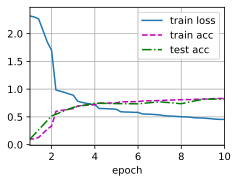

In [15]:
import torch
from torch import nn
from d2l import torch as d2l

# 创建一个LeNet模型，包括卷积层、池化层和全连接层
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

# 创建一个随机输入张量
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

# 遍历LeNet模型的各层并输出各层的输出形状
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期，并开始训练LeNet模型
lr, num_epochs = 0.9, 10

train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp; 代码验证如下：

loss 0.436, train acc 0.837, test acc 0.831
115053.0 examples/sec on cuda:0


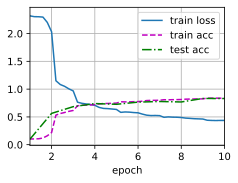

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义一个包含最大池化层的LeNet模型
net_maxpool = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),  # 第一个卷积层
    nn.MaxPool2d(kernel_size=2, stride=2),  # 第一个最大池化层
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),  # 第二个卷积层
    nn.MaxPool2d(kernel_size=2, stride=2),  # 第二个最大池化层
    nn.Flatten(),  # 展平操作，将多维张量展平为一维
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),  # 第一个全连接层
    nn.Linear(120, 84), nn.Sigmoid(),  # 第二个全连接层
    nn.Linear(84, 10))  # 输出层，共10个类别

# 创建一个随机输入张量
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

# 遍历LeNet模型的各层并输出各层的输出形状
for layer in net_maxpool:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net_maxpool, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


&emsp;&emsp; 可见用最大汇聚层替换平均汇聚层后，在训练集和测试集上均得到了更好的结果

### 练习 6.6.2

尝试构建一个基于LeNet的更复杂的网络，以提高其准确性。
1. 调整卷积窗口大小。
2. 调整输出通道的数量。
3. 调整激活函数（如ReLU）。
4. 调整卷积层的数量。
5. 调整全连接层的数量。
6. 调整学习率和其他训练细节（例如，初始化和轮数）。

**解答：** 

**第1问：**

loss 0.429, train acc 0.841, test acc 0.838
116518.4 examples/sec on cuda:0


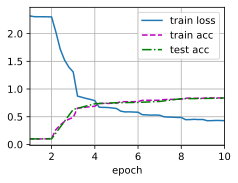

In [17]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为6。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 6, kernel_size=5, padding=2), 
    # Sigmoid激活函数，将卷积层的输出映射到(0, 1)区间，增加非线性。
    nn.Sigmoid(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为6（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(6, 16, kernel_size=5), 
    # 再次应用Sigmoid激活函数。
    nn.Sigmoid(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(16 * 5 * 5, 120), 
    # 应用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 再次使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(84, 10))

# 打印每个层的形状
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**第2问：**

&emsp;&emsp; `nn.Conv2d(1, 10, kernel_size = 5)`

loss 0.410, train acc 0.848, test acc 0.747
97512.0 examples/sec on cuda:0


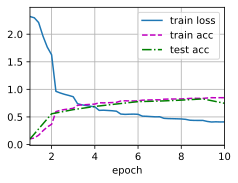

In [18]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为6。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # Sigmoid激活函数，将卷积层的输出映射到(0, 1)区间，增加非线性。
    nn.Sigmoid(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为6（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 再次应用Sigmoid激活函数。
    nn.Sigmoid(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(16 * 5 * 5, 120), 
    # 应用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 再次使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(84, 10))

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**第3问：**

&emsp;&emsp; `nn.Conv2d(1, 6, kernel_size = 5).ReLU()`或者直接将`nn.Sigmoid()`改为`nn.ReLU()`

loss 0.264, train acc 0.901, test acc 0.866
110692.1 examples/sec on cuda:0


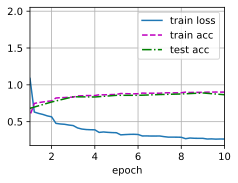

In [19]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为6。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # Sigmoid激活函数，将卷积层的输出映射到(0, 1)区间，增加非线性。
    nn.ReLU(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为6（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 再次应用Sigmoid激活函数。
    nn.ReLU(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(16 * 5 * 5, 120), 
    # 应用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 再次使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(84, 10))

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**第4问：**

&emsp;&emsp; 添加`conv3`为`nn.Cov2d(16, 120, kernel_size = 5). ReLU()`

loss 1.558, train acc 0.820, test acc 0.827
90555.1 examples/sec on cuda:0


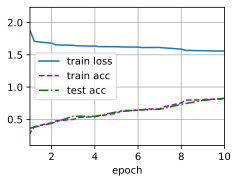

In [20]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为6。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # Sigmoid激活函数，将卷积层的输出映射到(0, 1)区间，增加非线性。
    nn.ReLU(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为6（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 再次应用Sigmoid激活函数。
    nn.ReLU(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 120, kernel_size = 5),
    nn.ReLU(),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(120, 120), 
    # 应用Sigmoid激活函数。
    nn.ReLU(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 再次使用Sigmoid激活函数。
    nn.ReLU(),
    # 第三个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(84, 10),
    nn.Sigmoid())

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**第5问：**

&emsp;&emsp; 添加`nn.Linear(84, 20)`并将`nn.Linear(84, 10)`替换为`nn.Linear(20, 10)`，添加`nn.Sigmoid()`

loss 0.278, train acc 0.898, test acc 0.886
89138.9 examples/sec on cuda:0


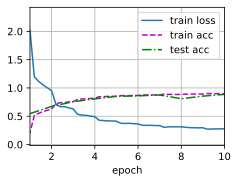

In [21]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为6。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # Sigmoid激活函数，将卷积层的输出映射到(0, 1)区间，增加非线性。
    nn.ReLU(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为6（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 再次应用Sigmoid激活函数。
    nn.ReLU(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 120, kernel_size = 5),
    nn.ReLU(),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(120, 120), 
    # 应用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 再次使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(84, 20),
    nn.Sigmoid(),
    nn.Linear(20, 10))

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**第6问：**

&emsp;&emsp; `lr, num_epochs = 0.1, 50`

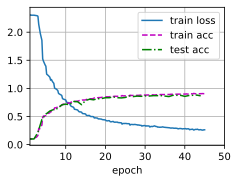

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为6。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # Sigmoid激活函数，将卷积层的输出映射到(0, 1)区间，增加非线性。
    nn.ReLU(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为6（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 再次应用Sigmoid激活函数。
    nn.ReLU(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 120, kernel_size = 5),
    nn.ReLU(),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(120, 120), 
    # 应用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 再次使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(84, 20),
    nn.Sigmoid(),
    nn.Linear(20, 10))

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.1, 50

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习 6.6.3

在MNIST数据集上尝试以上改进的网络。

**解答：** 

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义一个包含改进的LeNet模型
net_improve = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=3, padding=2), nn.ReLU(),  # 第一个卷积层
    nn.AvgPool2d(kernel_size=2, stride=2),  # 第一个平均池化层
    nn.Conv2d(6, 10, kernel_size=3), nn.ReLU(),  # 第二个卷积层
    nn.AvgPool2d(kernel_size=2, stride=2),  # 第二个平均池化层
    nn.Conv2d(10, 16, kernel_size=3), nn.ReLU(),  # 第三个卷积层
    nn.AvgPool2d(kernel_size=2, stride=2),  # 第三个平均池化层
    nn.Flatten(),  # 展平操作，将多维张量展平为一维
    nn.Linear(16 * 2 * 2, 120), nn.ReLU(),  # 第一个全连接层
    nn.Linear(120, 84), nn.ReLU(),  # 第二个全连接层
    nn.Linear(84, 20), nn.ReLU(),  # 第三个全连接层
    nn.Linear(20, 10))  # 输出层，共10个类别

# 创建一个随机输入张量
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

# 遍历改进的LeNet模型的各层并输出各层的输出形状
for layer in net_improve:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')
# 设置学习率和训练周期
lr, num_epochs = 0.1, 50

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net_improve, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp; 改进之后的网络在训练集和测试集上均表现出了更好的效果

### 练习 6.6.4

显示不同输入（例如毛衣和外套）时，LeNet第一层和第二层的激活值。

**解答：** 

&emsp;&emsp; 通过在所有epoch结束后添加`d2l.show_images`展示了激活值

loss 0.508, train acc 0.811, test acc 0.801
116449.4 examples/sec on cuda:0


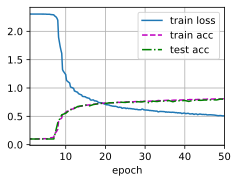

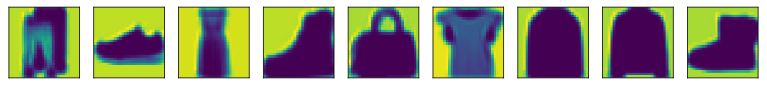

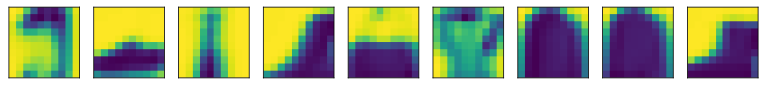

In [24]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义一个包含多个卷积层和全连接层的LeNet模型
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),  # 第一个卷积层
    nn.AvgPool2d(kernel_size=2, stride=2),  # 第一个平均池化层
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),  # 第二个卷积层
    nn.AvgPool2d(kernel_size=2, stride=2),  # 第二个平均池化层
    nn.Flatten(),  # 展平操作，将多维张量展平为一维
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),  # 第一个全连接层
    nn.Linear(120, 84), nn.Sigmoid(),  # 第二个全连接层
    nn.Linear(84, 10))  # 输出层，共10个类别

# 创建一个随机输入张量
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

# 遍历LeNet模型的各层并输出各层的输出形状
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 设置训练批量大小
batch_size = 256

# 加载Fashion MNIST数据集并创建训练和测试迭代器
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义一个用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义一个函数来在GPU上训练模型
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))

    # 以下代码用于可视化模型中的某些层的输出
    x_first_Sigmoid_layer = net[0:2](X)[0:9, 1, :, :]
    d2l.show_images(x_first_Sigmoid_layer.reshape(9, 28, 28).cpu().detach(), 1, 9)
    x_second_Sigmoid_layer = net[0:5](X)[0:9, 1, :, :]
    d2l.show_images(x_second_Sigmoid_layer.reshape(9, 10, 10).cpu().detach(), 1, 9)

    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.1, 50

# 调用train_ch6函数来在GPU上训练模型
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
